## Compare correlated predictions

In [94]:
import csv, random
import pandas as pd
import numpy as np
import math, sys
from collections import Counter
from scipy import spatial
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
%matplotlib inline
from sklearn.manifold import MDS
import statsmodels.api as sm

In [2]:
genrenamedf = pd.read_csv('../metadata/selected_genres.tsv', sep = '\t')
primaries = genrenamedf.loc[genrenamedf.genretype == 'primary', 'genre'].tolist()
bgenres = genrenamedf.loc[genrenamedf.genretype == 'B genre', 'genre'].tolist()
intersection_genres = set(genrenamedf.loc[genrenamedf.genretype == 'intersection', 'genre'].tolist())

def compress(aname):
    aname = aname.replace(':', '')
    aname = aname.replace(' ', '')
    aname = aname.replace(',', '')
    return aname

In [24]:
crossdict = dict()
for filepath in ['../results/crosscomparisons.tsv', '../results/localcrosscomparisons.tsv', '../results/selfcrosscomparisons.tsv']:
    crosses = pd.read_csv(filepath, sep = '\t')
    for idx, row in crosses.iterrows():
        if row.testype.startswith('self'):
            continue
        g1 = row.name1.split('_')[0]
        g2 = row.name2.split('_')[0]

        if g1.startswith('random') or g2.startswith('random'):
            continue

        if g1 not in crossdict:
            crossdict[g1] = dict()

        if g2 not in crossdict:
            crossdict[g2] = dict()

        if g2 not in crossdict[g1]:
            crossdict[g1][g2] = [float(row.spearman)]
        else:
            crossdict[g1][g2].append(float(row.spearman))

        if g1 not in crossdict[g2]:
            crossdict[g2][g1] = [float(row.spearman)]
        else:
            crossdict[g2][g1].append(float(row.spearman))

avgcross = dict()
for k1, v1 in crossdict.items():
    avgcross[k1] = dict()
    for k2, v2 in v1.items():
        avgcross[k1][k2] = 1.4 - (sum(v2) / len(v2))

In [45]:
withoverlap = dict()
sansoverlap = dict()

for g1 in primaries:
    if g1.startswith('random') or g1.endswith(' B'):
        continue
    withoverlap[g1] = dict()
    sansoverlap[g1] = dict()
    
    for g2 in primaries:
        intersected = g1 + '-Not-' + g2
        flipintersect = g2 + '-Not-' + g1
        
        if g2.startswith('random') or g2.endswith(' B'):
            continue 
            
        if g1 == g2:
            bversion = g1 + ' B'
            if bversion in bgenres:
                sanskey1 = compress(g1)
                sanskey2 = compress(bversion)
                withkey1 = sanskey1
                withkey2 = sanskey2
            else:
                print(g1)
                withoverlap[g1][g1] = float('nan')
                sansoverlap[g1][g2] = float('nan')
                continue  
                
        elif intersected in intersection_genres:
            sanskey1 = compress(intersected)
            sanskey2 = compress(flipintersect)
            withkey1 = sanskey1
            withkey2 = sanskey2
        else:
            sanskey1 = compress(g1)
            sanskey2 = compress(g2)
            withkey1 = sanskey1
            withkey2 = sanskey2

        if sanskey1 in avgcross and withkey1 in avgcross:
            sansoverlap[g1][g2] = avgcross[sanskey1][sanskey2]
            withoverlap[g1][g2] = avgcross[withkey1][withkey2]
        else:
            withoverlap[g1][g2] = float('nan')
            sansoverlap[g1][g2] = float('nan')
            print('error', g1, g2, key1, key2)
        
        
        

Biographical
Adventure
Horror
Christian
Western
Political
War


In [18]:
social = pd.read_csv('../socialmeasures/pmidf.csv', index_col = 'index')

In [60]:
withmatrix = pd.DataFrame(withoverlap)
withmatrix

,Adventure,Bildungsroman,Biographical,Christian,Domestic,Fantasy,Historical,Horror,Humor,Juvenile,...,Subj: Humor,Subj: Juvenile,Subj: Man-woman,"Subj: SF, American","Subj: SF, Other","Subj: Short stories, American","Subj: Short stories, Other",Suspense,War,Western
Adventure,NaN,1.472170,1.412725,1.488186,1.765386,0.916206,1.180323,0.858033,1.365999,1.216277,...,1.299257,1.250020,1.864529,0.655798,0.524418,1.139979,1.772226,0.599002,0.898512,0.852136
Bildungsroman,1.472170,0.519227,1.642454,1.498786,0.818517,1.665496,1.668682,1.402656,1.283943,1.377567,...,1.315197,1.225433,1.143321,1.550948,1.660595,1.017948,1.652510,1.485074,1.694687,1.379690
Biographical,1.412725,1.642454,NaN,1.226686,1.727723,0.863480,0.703883,1.303520,1.827395,1.579598,...,1.671567,1.638282,1.704188,1.443181,1.489314,1.441788,1.216544,1.861443,0.969005,1.179226
Christian,1.488186,1.498786,1.226686,NaN,1.378209,1.037098,1.123192,1.378376,1.501902,1.042074,...,1.753772,1.177074,1.281973,1.154865,1.300052,1.541680,1.807849,1.387362,1.420547,1.128806
Domestic,1.765386,0.818517,1.727723,1.378209,0.519227,1.867619,1.571254,1.584249,1.182298,1.214560,...,1.469471,1.091297,0.880408,1.655644,1.862879,1.107384,1.629332,1.416491,1.714358,1.397141
Fantasy,0.916206,1.665496,0.863480,1.037098,1.867619,0.519227,0.850936,0.712987,1.712604,1.365005,...,1.854329,1.402955,1.655082,0.439537,0.232833,1.467549,1.558386,1.405233,0.895356,0.911653
Historical,1.180323,1.668682,0.703883,1.123192,1.571254,0.850936,0.519227,1.425590,1.910945,1.055117,...,1.814515,1.071494,1.774842,1.541440,1.526151,1.531110,1.396310,1.614186,0.913422,0.750366
Horror,0.858033,1.402656,1.303520,1.378376,1.584249,0.712987,1.425590,NaN,1.487847,1.517164,...,1.660145,1.542979,1.584749,0.476412,0.460575,1.050023,1.573057,0.920604,1.207100,1.118503
Humor,1.365999,1.283943,1.827395,1.501902,1.182298,1.712604,1.910945,1.487847,0.519227,1.491322,...,0.357485,1.564752,1.108978,1.388162,1.412730,1.421625,1.947463,1.196813,1.761391,1.710805
Juvenile,1.216277,1.377567,1.579598,1.042074,1.214560,1.365005,1.055117,1.517164,1.491322,0.519227,...,1.179580,0.148158,1.775056,1.387944,1.412016,1.241658,1.468255,1.372585,1.165932,1.037956


In [55]:
socialvals = []
topicvals = []

for idx1 in social.index:
    for idx2 in social.index:
        tval = withmatrix.loc[idx1, idx2]
        if pd.isnull(tval):
            continue
        else:
            sval = social.loc[idx1, idx2]
            socialvals.append(sval)
            topicvals.append(tval)

pearsonr(socialvals, topicvals)

(-0.51542673712601894, 4.2331635285224975e-70)

In [56]:
sansmatrix = pd.DataFrame(sansoverlap)

In [57]:
socialvals = []
topicvals = []

for idx1 in social.index:
    for idx2 in social.index:
        tval = sansmatrix.loc[idx1, idx2]
        if pd.isnull(tval):
            continue
        else:
            sval = social.loc[idx1, idx2]
            socialvals.append(sval)
            topicvals.append(tval)

pearsonr(socialvals, topicvals)

(-0.53394332979974402, 5.0225299163073163e-76)

In [59]:
def bootstrap(vec1, vec2):
    assert len(vec1) == len(vec2)
    n = len(vec1)
    indices = []
    for i in range(n):
        indices.append(random.randrange(n))
    bs1 = [vec1[x] for x in indices]
    bs2 = [vec2[x] for x in indices]
    return bs1, bs2

def boot_sample(vec1, vec2):
    corrs = []
    for i in range(1000):
        bs1, bs2 = bootstrap(vec1, vec2)
        r = pearsonr(bs1, bs2)
        corrs.append(r[0])
    corrs.sort()
    return corrs[50], corrs[950]

boot_sample(topicvals, socialvals)

(-0.57528476165628117, -0.49160263284562605)

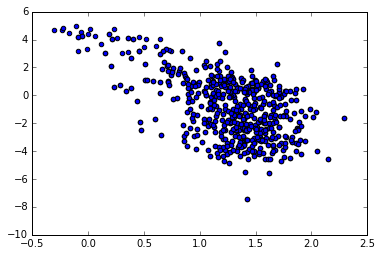

In [58]:
plt.scatter(topicvals, socialvals)

In [75]:
odict = dict()
for filepath in ['../results/overlapcrosscomparisons.tsv']:
    crosses = pd.read_csv(filepath, sep = '\t')
    for idx, row in crosses.iterrows():
        if row.testype.startswith('self'):
            continue
        g1 = row.name1.split('_')[0]
        g2 = row.name2.split('_')[0]

        if g1.startswith('random') or g2.startswith('random'):
            continue

        if g1 not in odict:
            odict[g1] = dict()

        if g2 not in odict:
            odict[g2] = dict()

        if g2 not in odict[g1]:
            odict[g1][g2] = [float(row.spearman)]
        else:
            odict[g1][g2].append(float(row.spearman))

        if g1 not in odict[g2]:
            odict[g2][g1] = [float(row.spearman)]
        else:
            odict[g2][g1].append(float(row.spearman))

avgwoverlap = dict()
for k1, v1 in odict.items():
    avgwoverlap[k1] = dict()
    for k2, v2 in v1.items():
        avgwoverlap[k1][k2] = 1.4 - (sum(v2) / len(v2))

In [76]:
withoverlap = dict()

for g1 in primaries:
    if g1.startswith('random'):
        continue

    withoverlap[g1] = dict()
    
    for g2 in primaries:
        if g2.startswith('random'):
            continue
            
        if g1 == g2:
            bversion = g1 + ' B'
            if bversion in bgenres:
                withkey1 = compress(g1)
                withkey2 = compress(bversion)
            else:
                print(g1)
                withoverlap[g1][g1] = float('nan')
                sansoverlap[g1][g2] = float('nan')
                continue  
                
        else:
            withkey1 = compress(g1)
            withkey2 = compress(g2)

        if withkey1 in avgwoverlap and withkey2 in avgwoverlap[withkey1]:
            withoverlap[g1][g2] = avgwoverlap[withkey1][withkey2]
        else:
            withoverlap[g1][g2] = float('nan')
            print('error', g1, g2, withkey1, withkey2)
        
        
        

Biographical
Adventure
Horror
Christian
Western
Political
War


In [77]:
withmatrix = pd.DataFrame(withoverlap)
withmatrix

,Adventure,Bildungsroman,Biographical,Christian,Domestic,Fantasy,Historical,Horror,Humor,Juvenile,...,Subj: Humor,Subj: Juvenile,Subj: Man-woman,"Subj: SF, American","Subj: SF, Other","Subj: Short stories, American","Subj: Short stories, Other",Suspense,War,Western
Adventure,NaN,1.489374,1.337094,1.488186,1.760672,0.954174,1.286684,0.858033,1.365999,1.216277,...,1.299257,1.250020,1.833253,0.655798,0.524418,1.139979,1.772226,0.599002,0.803138,0.738079
Bildungsroman,1.489374,0.647897,1.642454,1.498786,0.826277,1.665496,1.668682,1.402656,1.144117,1.377567,...,1.315197,1.225433,1.079117,1.550948,1.660595,1.017948,1.652510,1.431086,1.671868,1.379690
Biographical,1.337094,1.642454,NaN,1.374342,1.727723,0.863480,0.705722,1.303520,1.827395,1.579598,...,1.671567,1.638282,1.704188,1.443181,1.489314,1.441788,1.216544,1.861443,1.005829,1.069353
Christian,1.488186,1.498786,1.374342,NaN,1.129253,1.111329,1.123192,1.378376,1.408394,1.042074,...,1.753772,1.177074,1.281973,1.154865,1.300052,1.541680,1.807849,1.387362,1.420547,1.128806
Domestic,1.760672,0.826277,1.727723,1.129253,0.456464,1.867619,1.571254,1.584249,1.182298,1.214560,...,1.469471,1.091297,0.872550,1.655644,1.862879,1.107384,1.629332,1.416491,1.732612,1.397141
Fantasy,0.954174,1.665496,0.863480,1.111329,1.867619,0.064558,0.850936,0.647498,1.712604,1.365005,...,1.854329,1.402955,1.655082,0.439537,0.232833,1.467549,1.558386,1.405233,0.939208,0.911653
Historical,1.286684,1.668682,0.705722,1.123192,1.571254,0.850936,0.497984,1.425590,1.910945,1.055117,...,1.814515,1.071494,1.767657,1.541440,1.526151,1.531110,1.396310,1.614186,0.940463,0.750366
Horror,0.858033,1.402656,1.303520,1.378376,1.584249,0.647498,1.425590,NaN,1.487847,1.517164,...,1.660145,1.542979,1.584749,0.567156,0.465222,1.050023,1.573057,0.920604,1.207100,1.021673
Humor,1.365999,1.144117,1.827395,1.408394,1.182298,1.712604,1.910945,1.487847,0.261005,1.491322,...,0.357485,1.564752,1.108978,1.388162,1.412730,1.421625,1.947463,1.196813,1.761391,1.710805
Juvenile,1.216277,1.377567,1.579598,1.042074,1.214560,1.365005,1.055117,1.517164,1.491322,0.359930,...,1.179580,0.074400,1.775056,1.387944,1.412016,1.241658,1.468255,1.372585,1.165932,1.037956


In [78]:
socialvals = []
topicvals = []

for idx1 in social.index:
    for idx2 in social.index:
        tval = withmatrix.loc[idx1, idx2]
        if pd.isnull(tval):
            continue
        else:
            sval = social.loc[idx1, idx2]
            socialvals.append(sval)
            topicvals.append(tval)

pearsonr(socialvals, topicvals)

(-0.54255946436819313, 6.5424419796665326e-79)

In [82]:
# Now let's use all the comparisons.

allcomparisons = dict()

for g1 in bgenres:
    bless1 = g1[0 : -2]
    allcomparisons[bless1] = dict()
    
    for g2 in bgenres:
        bless2 = g2[0 : -2]
        
        bkey1 = compress(bless1)
        bkey2 = compress(bless2)
        key1 = compress(g1)
        key2 = compress(g2)
        
        allcomparisons[bless1][bless2] = []
        allcomparisons[bless1][bless2].append(avgwoverlap[key1][bkey2])
        allcomparisons[bless1][bless2].append(avgwoverlap[bkey1][key2])
        if not g1 == g2:
            allcomparisons[bless1][bless2].append(avgwoverlap[bkey1][bkey2])
            allcomparisons[bless1][bless2].append(avgwoverlap[key1][key2])
        
        allcomparisons[bless1][bless2] = sum(allcomparisons[bless1][bless2]) / len(allcomparisons[bless1][bless2])

allmatrix = pd.DataFrame(allcomparisons)
allmatrix

,Bildungsroman,Domestic,Fantasy,Historical,Humor,Juvenile,Love,Mystery,Novel,Psychological,...,Subj: History,Subj: Horror,Subj: Humor,Subj: Juvenile,Subj: Man-woman,"Subj: SF, American","Subj: SF, Other","Subj: Short stories, American","Subj: Short stories, Other",Suspense
Bildungsroman,0.647897,0.704715,1.679645,1.649937,1.222403,1.345242,1.045801,1.375028,1.522689,1.010098,...,1.836131,1.462553,1.241319,1.299763,1.081002,1.511836,1.675698,0.960495,1.568517,1.452127
Domestic,0.704715,0.456464,1.869475,1.629198,1.227423,1.134912,0.831948,1.275747,1.542838,0.932354,...,1.968450,1.590011,1.382744,1.137701,0.880017,1.647614,1.878340,1.089272,1.632260,1.410400
Fantasy,1.679645,1.869475,0.064558,0.911674,1.736909,1.323455,1.482691,1.546981,1.177987,1.604011,...,0.870368,0.763902,1.875572,1.247907,1.780047,0.538318,0.363191,1.421803,1.519503,1.363561
Historical,1.649937,1.629198,0.911674,0.497984,1.873623,1.217652,1.507611,1.686287,1.303520,1.853047,...,0.713994,1.487528,1.805862,1.154825,1.803724,1.629708,1.593842,1.490226,1.366815,1.611710
Humor,1.222403,1.227423,1.736909,1.873623,0.261005,1.435273,1.341596,0.977630,1.460326,1.127468,...,1.828494,1.590323,0.362500,1.514211,1.079862,1.321777,1.348464,1.381552,1.930738,1.161047
Juvenile,1.345242,1.134912,1.323455,1.217652,1.435273,0.359930,1.635468,1.488830,1.391971,1.679019,...,1.237281,1.598485,1.152631,0.241465,1.677355,1.465800,1.560729,1.186750,1.452234,1.327679
Love,1.045801,0.831948,1.482691,1.507611,1.341596,1.635468,0.604237,1.253400,1.318274,1.073132,...,1.764840,1.429811,1.760389,1.579908,0.773341,1.432486,1.640995,1.374432,1.767467,1.400316
Mystery,1.375028,1.275747,1.546981,1.686287,0.977630,1.488830,1.253400,-0.013493,1.175882,1.077296,...,1.656106,1.135809,1.087084,1.538421,1.323779,1.155255,1.258082,1.410669,2.081936,0.263840
Novel,1.522689,1.542838,1.177987,1.303520,1.460326,1.391971,1.318274,1.175882,1.173506,1.465787,...,1.243971,1.348158,1.632472,1.403301,1.491933,1.329482,1.333748,1.555141,1.614052,1.152130
Psychological,1.010098,0.932354,1.604011,1.853047,1.127468,1.679019,1.073132,1.077296,1.465787,0.739900,...,1.921001,1.258868,1.394369,1.672788,1.007109,1.199769,1.238842,1.204746,1.717172,1.192076


In [83]:
socialvals = []
topicvals = []

for idx1 in allmatrix.index:
    for idx2 in allmatrix.index:
        tval = allmatrix.loc[idx1, idx2]
        if pd.isnull(tval):
            continue
        else:
            sval = social.loc[idx1, idx2]
            socialvals.append(sval)
            topicvals.append(tval)

pearsonr(socialvals, topicvals)

(-0.62783134577367838, 8.0796539601926331e-70)

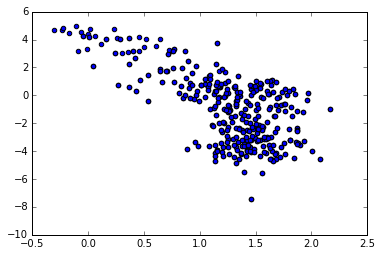

In [86]:
plt.scatter(topicvals, socialvals)
plt.show()

In [90]:
scaler = MDS(metric = True, dissimilarity = 'precomputed')
coordinates = scaler.fit_transform(allmatrix)

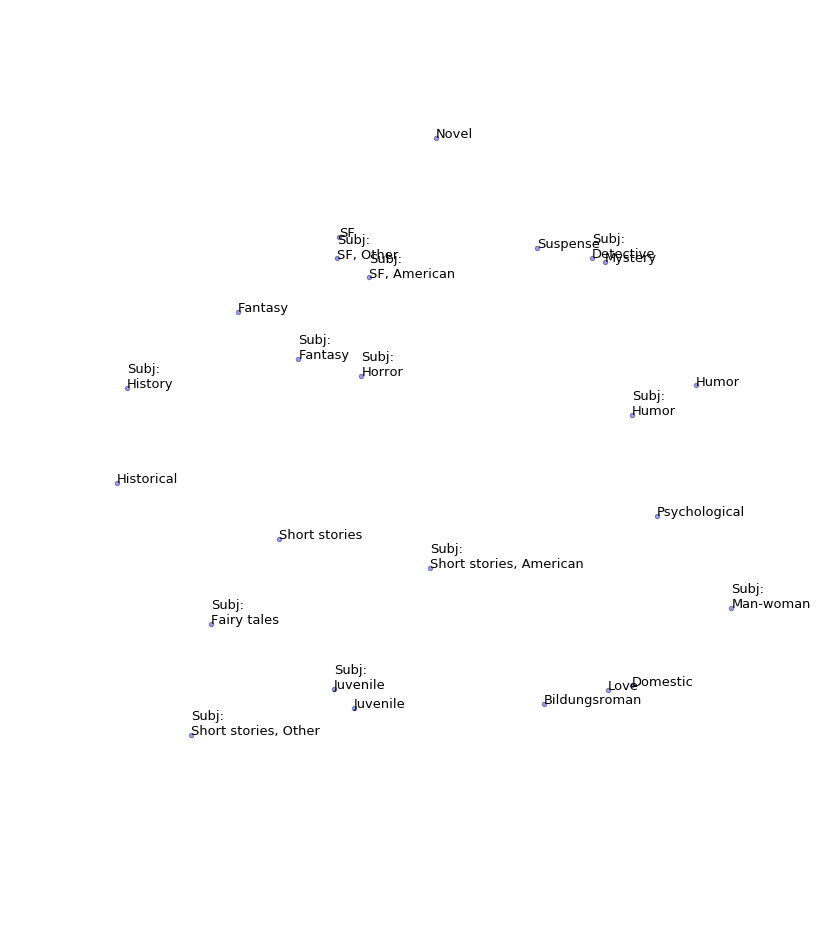

In [91]:
fig, ax = plt.subplots(figsize = (14, 16))
genres = allmatrix.index.tolist()
colors=np.linspace(0, 1, 7)
ax.scatter(coordinates[ :, 0], coordinates[ : , 1], alpha = 0.4)
#ax.set_xlim((-0.65, 1.35))
# ax.set_ylim((-1.9, 2.1))
for i in range(len(genres)):
    thisx = coordinates[i, 0]
    thisy = coordinates[i, 1]
    name = genres[i]
    plotname = name.replace(': ', ':\n')
    ax.annotate(plotname, (thisx, thisy), fontsize = 13)
plt.axis('off')
# plt.savefig('new2detectiveMDS.png', bbox_inches = 'tight')
plt.show()

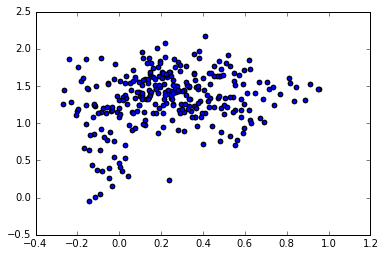

In [89]:
selfavg = []
compared = []

for idx1 in allmatrix.index:
    for idx2 in allmatrix.index:
        if idx1 == idx2:
            continue
            
        self1 = allmatrix.loc[idx1, idx1]
        self2 = allmatrix.loc[idx2, idx2]
        compare = allmatrix.loc[idx1, idx2]
        
        if pd.isnull(self1) and pd.isnull(self2):
            continue
        elif pd.isnull(self1):
            theself = self2
        elif pd.isnull(self2):
            theself = self1
        else:
            theself = (self1 + self2) / 2
        
        compared.append(compare)
        selfavg.append(theself)

plt.scatter(selfavg, compared)

In [88]:
pearsonr(selfavg, compared)

(0.2356293195663533, 5.1535770029047557e-09)

In [95]:
df = pd.DataFrame({'x': selfavg, 'y': compared})
X = df[['x']]
y = df['y']
mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     592.6
Date:                Fri, 18 May 2018   Prob (F-statistic):           1.61e-91
Time:                        22:42:34   Log-Likelihood:                -836.17
No. Observations:                 600   AIC:                             1674.
Df Residuals:                     599   BIC:                             1679.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x              2.7847      0.114     24.342      0.000       2.560       3.009
==============================================================================
Omnibus:                       10.214   Durbin-Watson:                   0.688
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.546
Skew:                          -0.318   Prob(JB):                      0.00513
Kurtosis:                       2.869   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""